In [ ]:
!pip install nltk>=3.0 numpy==1.21.6 matplotlib torch fasttext scikit-learn~=0.24.2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fasttext
import torch
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
sys.path.append('DialogueActClassification')

from dialogue_classification.dataset_utils import load_swda_corpus_data
from dialogue_classification.dataset import FasttextDataset
from dialogue_classification.models import DialogueNetFasttext
from dialogue_classification.train_test_split import train_set_idx, valid_set_idx, test_set_idx
from dialogue_classification.training import train_model

/Users/e.trufanova/.pyenv/versions/3.8.6/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

In [4]:
!gzip -dk cc.en.300.bin.gz

## Prepare data

In [3]:
talks, talk_names, tag_indices, tag_occurances = load_swda_corpus_data('swda/swda/swda')

Loading SwDA Corpus...

Found 43 different utterance tags.

Loaded SwDA Corpus.


In [4]:
len(talks), len(tag_indices)

(1155, 43)

In [5]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub("[,']+", '', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\?', ' ? ', text)
    text = re.sub('!', ' ! ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [6]:
texts, labels = [], []
for text, label in talks:
    assert len(text) == len(label)
    text = [' '.join(utterance) for utterance in text]
    texts.append(text)
    labels.append(label)

In [7]:
texts = [[preprocess(utt) for utt in text] for text in texts]

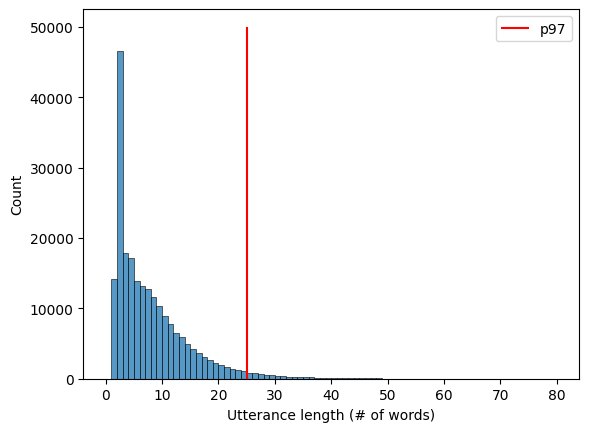

count    221616.000000
mean          7.634850
std           6.896954
min           0.000000
25%           2.000000
50%           6.000000
75%          10.000000
max          80.000000
dtype: float64

In [8]:
utterance_lens = [len(utterance.split()) for utterance in sum(texts, [])]
utterance_lens = pd.Series(utterance_lens)

sns.histplot(utterance_lens, binwidth=1)
plt.vlines(utterance_lens.quantile(0.97), 0, 50_000, color='red', label='p97')
plt.xlabel("Utterance length (# of words)")
plt.legend()
plt.show()

utterance_lens.describe()

In [9]:
utterance_lens.quantile(0.97) # => max_length = 30

25.0

In [10]:
max_length = 30

In [11]:
train_idx = np.isin(talk_names, train_set_idx)
valid_idx = np.isin(talk_names, valid_set_idx)
test_idx = np.isin(talk_names, test_set_idx)

In [12]:
texts, labels = np.array(texts), np.array(labels)

train_texts, train_labels = texts[train_idx], labels[train_idx]
valid_texts, valid_labels = texts[valid_idx], labels[valid_idx]
test_texts, test_labels = texts[test_idx], labels[test_idx]

/var/folders/pk/0hw9m8496w7gxnl1pfsssfdddh310s/T/ipykernel_76048/1925198038.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  texts, labels = np.array(texts), np.array(labels)


In [13]:
del texts, labels, talks

## Fasttext embeddings

In [14]:
fasttext_model = fasttext.load_model("cc.en.300.bin")

In [15]:
EPS = 1e-5

def l2_norm(vector):
    return vector / (np.linalg.norm(vector) + EPS)


def get_fasttext_embeddings(texts):
    fasttext_embs = []
    for text in tqdm(texts):
        utterance_embs = [] 
        for utterance in text:
            if not utterance.split():
                embs = torch.Tensor(0, fasttext_model.get_dimension())
            else:
                embs = torch.Tensor(
                    np.stack([
                      l2_norm(fasttext_model.get_word_vector(word))
                      for word in utterance.split()
                    ])
                  )
            if len(embs) > max_length:
                embs = embs[:max_length]
            if len(embs) < max_length:
                padding_shape = (max_length - len(embs), fasttext_model.get_dimension())
                embs = torch.cat((torch.zeros(padding_shape), embs), axis=0)
            utterance_embs.append(embs)
        fasttext_embs.append(torch.stack(utterance_embs))

    dialogue_lengths = [len(dialogue) for dialogue in fasttext_embs]
    dialogue_lengths = torch.LongTensor(dialogue_lengths)

    fasttext_embs = pad_sequence(fasttext_embs, batch_first=True)

    return fasttext_embs, dialogue_lengths

In [16]:
test_embs, test_lengts = get_fasttext_embeddings(test_texts)
valid_embs, valid_lengts = get_fasttext_embeddings(valid_texts)
train_embs, train_lengts = get_fasttext_embeddings(train_texts)

train_embs.size(), valid_embs.size(), test_embs.size()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1003/1003 [00:15<00:00, 65.25it/s]


(torch.Size([1003, 540, 30, 300]),
 torch.Size([112, 394, 30, 300]),
 torch.Size([19, 388, 30, 300]))

In [17]:
del fasttext_model

## Training

In [18]:
train_labels = [torch.LongTensor(label) for label in train_labels]
train_labels = pad_sequence(train_labels, batch_first=True)

valid_labels = [torch.LongTensor(label) for label in valid_labels]
valid_labels = pad_sequence(valid_labels, batch_first=True)

test_labels = [torch.LongTensor(label) for label in test_labels]
test_labels = pad_sequence(test_labels, batch_first=True)

In [19]:
batch_size = 32

train_set = FasttextDataset(train_embs, train_lengts, train_labels)
valid_set = FasttextDataset(valid_embs, valid_lengts, valid_labels)
test_set = FasttextDataset(test_embs, test_lengts, test_labels)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [20]:
net = DialogueNetFasttext(
    input_size=300, 
    output_size=len(tag_occurances), 
    rnn_hidden_size=128, 
    use_layer_norm=True, 
    max_utterance_len=max_length,
)

net

DialogueNetFasttext(
  (rnn_embedder): RNNEmbedder(
    (rnn): GRU(300, 128, batch_first=True, bidirectional=True)
  )
  (dialogue_rnn): DialogueRNN(
    (rnn): GRU(256, 128, batch_first=True)
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (head): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=43, bias=True)
    )
  )
)

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.01)

[EPOCH 0] Train loss: 2.1569758355617523
[EPOCH 0] Val loss: 1.6215979158878326, F1-score: 0.5408546839449995
[EPOCH 0] Test loss: 1.6923454999923706, F1-score: 0.49490474080638014
[EPOCH 1] Train loss: 1.4027735851705074
[EPOCH 1] Val loss: 1.2336041331291199, F1-score: 0.6182114947076862
[EPOCH 1] Test loss: 1.3457103967666626, F1-score: 0.5624723083739477
[EPOCH 2] Train loss: 1.1046676971018314
[EPOCH 2] Val loss: 0.9988842308521271, F1-score: 0.6951231575823523
[EPOCH 2] Test loss: 1.1133297681808472, F1-score: 0.6535223748338502
[EPOCH 3] Train loss: 0.9527820367366076
[EPOCH 3] Val loss: 0.8835627436637878, F1-score: 0.7281630230487685
[EPOCH 3] Test loss: 0.9548056721687317, F1-score: 0.7042534337616305
[EPOCH 4] Train loss: 0.8554622232913971
[EPOCH 4] Val loss: 0.8157291859388351, F1-score: 0.7484914432683747
[EPOCH 4] Test loss: 0.8814233541488647, F1-score: 0.727292866637129
[EPOCH 5] Train loss: 0.7931054085493088
[EPOCH 5] Val loss: 0.7624399065971375, F1-score: 0.7615985

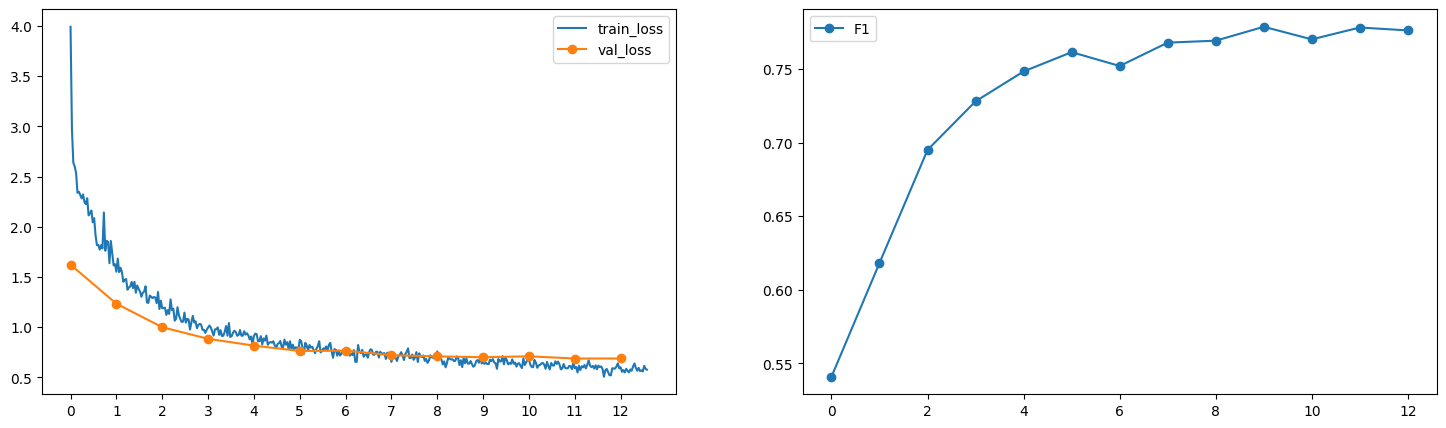

In [36]:
train_model(net, train_loader, valid_loader, test_loader, optimizer,
            bert_finetuning_epochs=None, n_epochs=100, verbose=True, plot=True)